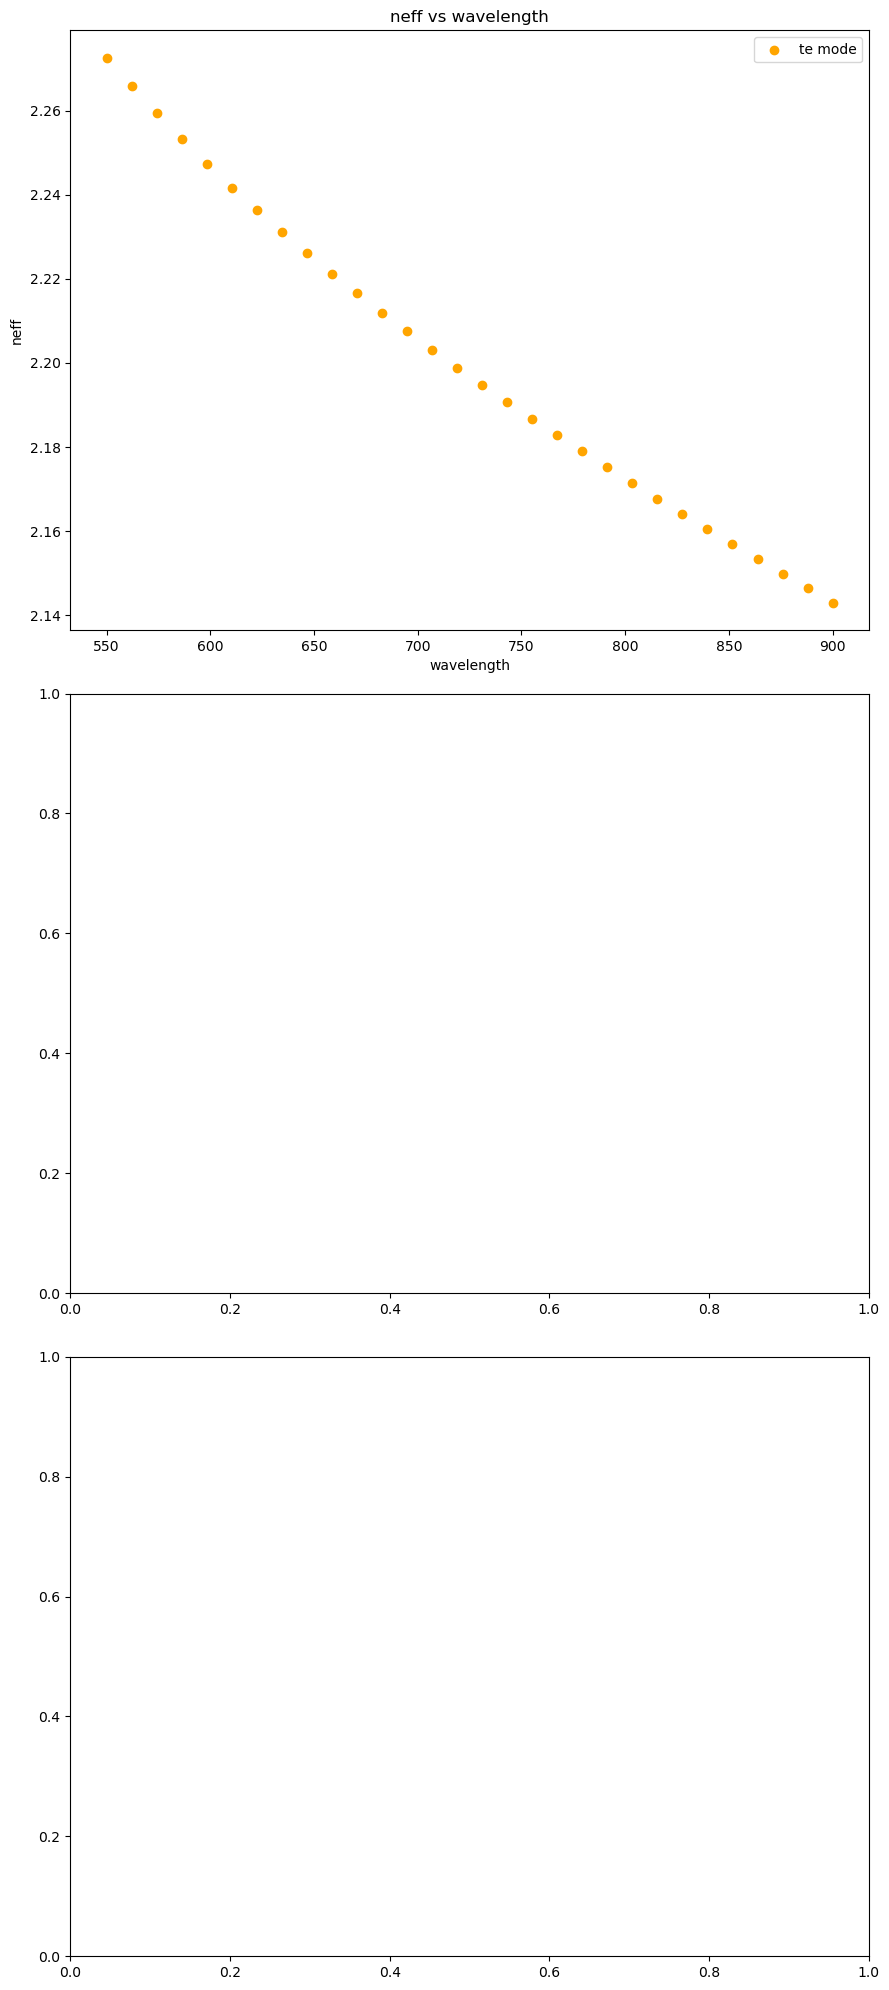

In [2]:
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light as c
import pandas as pd
# waveguide parameters
#bottom_width = 2 # um
top_width = 1.15
box_height = 5
triangle_height = 0.6
ray = "o"


data = np.load(f"data_h_{triangle_height}_w_{top_width}_{ray}.npz")
neff_list_te = np.array(np.real(data['neff_list_te']))
wls = data["wls"]

fig, axs = plt.subplots(3, 1, figsize=(9,20))

#-----------fit neff spline----------------------------------
y_spl_te = UnivariateSpline(wls,neff_list_te,s=0,k=3)
w_range = np.linspace(wls[0],wls[-1],1000)

#-----------neff plot-----------------
axs[0].set_xlabel("wavelength")
axs[0].set_ylabel("neff")
axs[0].set_title("neff vs wavelength")
axs[0].scatter(wls,neff_list_te, color="orange", label = "te mode")
axs[0].legend()

plt.tight_layout()
plt.show()